In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from scipy.special import logsumexp

### Model

$$X_t = \phi X_{t-1} + W_t$$
$$Y_t = V_tX_t$$

$$V_t \sim N(1, 0.1^2)$$
$$W_t \sim N(0, 1)$$

In [5]:
def simulate(T, phi, seed=0):
    np.random.seed(seed)
    x = np.zeros(T)    
    x[0] = np.random.normal()
    
    for t in range(1, T):
        x[t] = np.random.normal(loc=phi*x[t-1])
    y = x * np.random.normal(loc=1,scale=0.01,size=T)

    return x, y

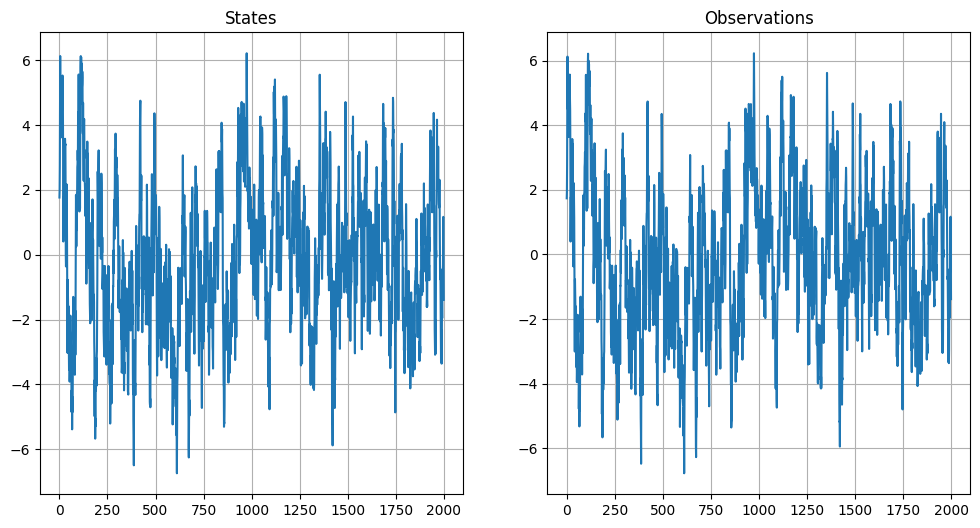

In [6]:
T= 2000 # time steps
phi = 0.9 
states, observations = simulate(T, phi)
fig, ax = plt.subplots(figsize=(12, 6),ncols=2, nrows=1)
ax[0].plot(states)
ax[0].set_title('States')
ax[0].grid()
ax[1].plot(observations)
ax[1].set_title('Observations')
ax[1].grid()

Below is the code implementing the parameter estimation scheme

In [11]:
def q(y, x):
    return st.norm.pdf(y, loc=x, scale=0.1)


def log_q(y, x):
    return st.norm.logpdf(y, loc=x, scale=0.1)


def p(x_2, x_1, phi):
    return st.norm.pdf(
        x_2,
        loc=phi * x_1,
    )


def resample_propogate_log(N, observation, particles, phi):
    logw = log_q(observation, particles)
    logw -= logsumexp(logw)
    w = np.exp(logw)
    s = np.sum(w)
    if s == 0 or not np.isfinite(s):
        w = np.ones(N) / N
    else:
        w /= s
    resamples = np.random.choice(a=particles, size=N, p=w)
    particles = np.random.normal(
        loc=phi * resamples,
    )
    return particles


def d_phi(phi, x_2, x_1):  # dphi/dp = d(logphi)/dphi * phi
    return p(x_2, x_1, phi) * ((x_2 - phi * x_1) * x_1)


def a(n):  # step size
    return 1 / (n + 1)


def estimate_params(T, observations, N=1000):
    # initial config
    phi = 0.1
    particles = np.random.normal(loc=0, size=N)
    weights = 1 / N * np.ones(N)
    # weights = np.zeros(N)

    param_evolution = [phi]
    for j in range(T - 1):
        observation = observations[j]
        next_particles = resample_propogate_log(N, observation, particles, phi)
        next_observation = observations[j + 1]
        new_weights = np.empty(N)
        for i in range(N):
            normaliser = np.sum(
                (p(next_particles[i], particles, phi) * q(observation, particles))
            )
            if normaliser == 0:
                continue
            new_weights[i] = (
                np.sum(
                    d_phi(phi, next_particles[i], particles) * q(observation, particles)
                )
                + np.sum(
                    p(next_particles[i], particles, phi)
                    * q(observation, particles)
                    * weights
                )
            ) / normaliser

        new_weights = new_weights - np.mean(new_weights)
        normaliser = np.sum(q(next_observation, next_particles))
        if normaliser != 0:  # normaliser == 0 iff all probabilities are zero
            phi += (
                a(j)
                * np.sum(q(next_observation, next_particles) * new_weights)
                / normaliser
            )
            phi = min(max(phi, 0.001), 2)

        weights = new_weights
        param_evolution.append(phi)

        print(f"Iteration {j + 1}/{T - 1} phi:{phi})")

        particles = next_particles
    return param_evolution

In [2]:
def plot_param_estimation(guesses):
    guesses = np.array(guesses)

    phis = guesses

    fig, ax = plt.subplots()
    ax.plot(phis, label="phi", color="green")
    ax.hlines(y=phi, xmin=0, xmax=len(phis),label="true phi", linestyle="dashed", color="red")
    fig.legend()
    ax.grid()
    fig.set_figheight(6)
    fig.set_figwidth(10)

In [7]:
guesses = estimate_params(T=500, observations=observations, N=1000)

Iteration 1/499 phi:2)
Iteration 2/499 phi:1.0306154910382554)
Iteration 3/499 phi:2)
Iteration 4/499 phi:0.001)
Iteration 5/499 phi:2)
Iteration 6/499 phi:1.3571268140981267)
Iteration 7/499 phi:0.001)
Iteration 8/499 phi:1.819208279902546)
Iteration 9/499 phi:1.0294851199135313)
Iteration 10/499 phi:0.8718553212719424)
Iteration 11/499 phi:1.3735296394437504)
Iteration 12/499 phi:0.8615417578437562)
Iteration 13/499 phi:0.990509301981346)
Iteration 14/499 phi:1.0053204312046888)
Iteration 15/499 phi:0.9377963860465451)
Iteration 16/499 phi:1.3228399565056297)
Iteration 17/499 phi:0.5041271876198311)
Iteration 18/499 phi:1.0514466397519011)
Iteration 19/499 phi:0.7362285329504424)
Iteration 20/499 phi:0.39746518268267694)
Iteration 21/499 phi:0.4138827389715068)
Iteration 22/499 phi:0.47345256292160415)
Iteration 23/499 phi:0.47625689689214107)
Iteration 24/499 phi:0.5751517114040533)
Iteration 25/499 phi:0.5255924565160466)
Iteration 26/499 phi:0.5502974460435271)
Iteration 27/499 ph

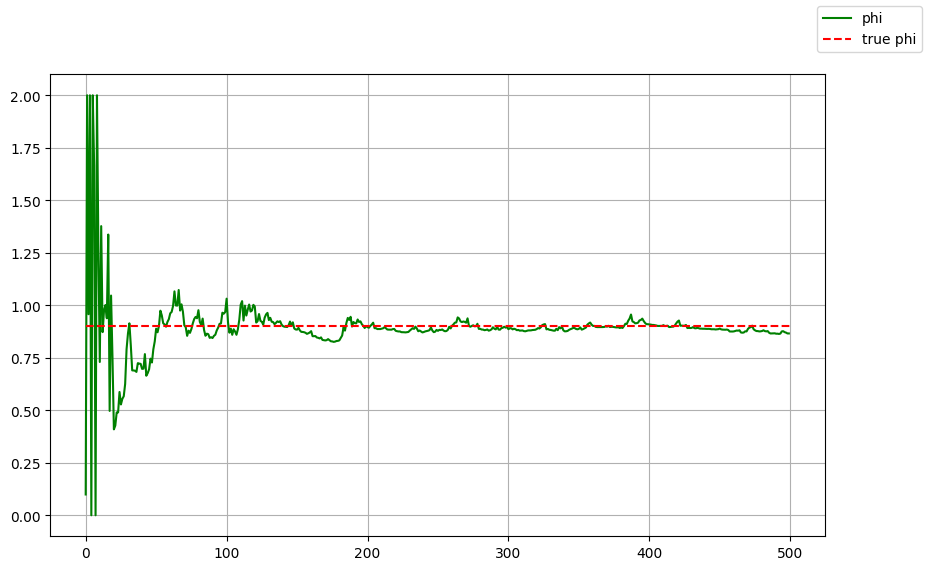

In [12]:
plot_param_estimation(guesses)

Below is the vectorised code, created with the help of ai, verified numerically

In [23]:
def estimate_params_vec(T, observations, N=1000, seed=0):
    np.random.seed(seed)
    phi = 0.1
    particles = np.random.normal(0, 1, size=N)
    weights = np.zeros(N)

    param_evolution = [phi]

    for j in range(T - 1):
        y_t = observations[j]
        y_next = observations[j + 1]

        next_particles = resample_propogate_log(N, y_t, particles, phi)

        # Shape: (N, N)
        P = p(next_particles[:, None], particles[None, :], phi)
        Q = q(y_t, particles)

        normalisers = P @ Q  # (N,)
        valid = normalisers > 0

        dP = d_phi(phi, next_particles[:, None], particles[None, :])

        new_weights = np.zeros(N)
        new_weights[valid] = (
            (dP @ Q)[valid] + (P @ (Q * weights))[valid]
        ) / normalisers[valid]

        # center weights
        new_weights -= np.mean(new_weights)

        # phi updates
        q_next = q(y_next, next_particles)
        norm_phi = np.sum(q_next)

        if norm_phi > 0:
            phi += a(j) * np.sum(q_next * new_weights) / norm_phi

        # project phi
        phi = np.clip(phi, 0.001, 2)

        weights = new_weights
        particles = next_particles
        param_evolution.append(phi)

        print(f"Iteration {j + 1}/{T - 1}, phi = {phi}")

    return param_evolution

### Evaluating performance with varying particle count

In [47]:
bunch_of_guesses = [
    estimate_params(T=1500, observations=observations, N=(i+1)*500, seed=0)
    for i in range(5)
]

Iteration 1/1499, phi = 2.0
Iteration 2/1499, phi = 1.089920361489264
Iteration 3/1499, phi = 2.0
Iteration 4/1499, phi = 0.001
Iteration 5/1499, phi = 2.0
Iteration 6/1499, phi = 1.5195801335543357
Iteration 7/1499, phi = 0.001
Iteration 8/1499, phi = 1.9216227749085997
Iteration 9/1499, phi = 1.0732186382069253
Iteration 10/1499, phi = 0.8697151482631742
Iteration 11/1499, phi = 1.3489931969707538
Iteration 12/1499, phi = 0.8643652483132891
Iteration 13/1499, phi = 0.9735786602604725
Iteration 14/1499, phi = 0.9907763660790078
Iteration 15/1499, phi = 0.9649286650065263
Iteration 16/1499, phi = 1.3081216638603201
Iteration 17/1499, phi = 0.5156438021711826
Iteration 18/1499, phi = 1.0098548353740187
Iteration 19/1499, phi = 0.7552383884790875
Iteration 20/1499, phi = 0.41231664585276534
Iteration 21/1499, phi = 0.42913758950295366
Iteration 22/1499, phi = 0.489647752724665
Iteration 23/1499, phi = 0.4858945875098956
Iteration 24/1499, phi = 0.57815582399305
Iteration 25/1499, phi = 0

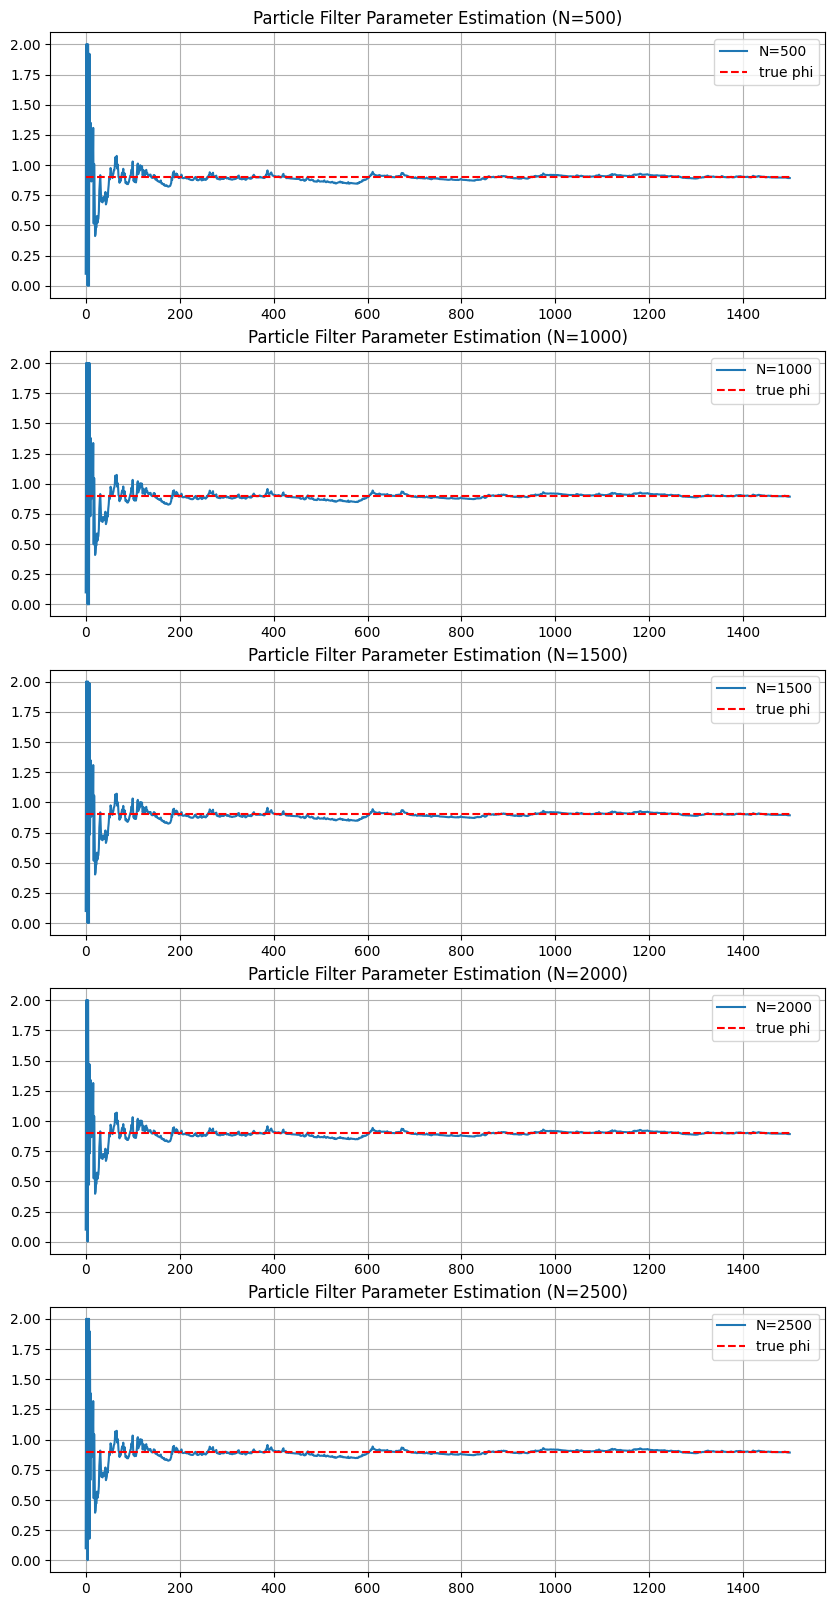

In [49]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 20))
for i, guesses in enumerate(bunch_of_guesses):
    ax[i].plot(guesses, label=f"N={(i+1)*500}")
    ax[i].hlines(y=phi, xmin=0, xmax=len(guesses), label="true phi", linestyle="dashed", color="red")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(f"Particle Filter Parameter Estimation (N={(i+1)*500})")

In [15]:
results = {}
for phi in np.linspace(0.1, 2, 10):
    states, observations = simulate(T, phi, seed=0)
    guesses = estimate_params_vec(T=200, observations=observations, N=1000)
    results[phi] = guesses

Iteration 1/199, phi = 0.8843651207050058
Iteration 2/199, phi = 1.0397798910695055
Iteration 3/199, phi = 1.4652920739637056
Iteration 4/199, phi = 0.7507748110570497
Iteration 5/199, phi = 0.001
Iteration 6/199, phi = 0.001
Iteration 7/199, phi = 0.001
Iteration 8/199, phi = 0.0020777741098607075
Iteration 9/199, phi = 0.001
Iteration 10/199, phi = 0.008887261661815929
Iteration 11/199, phi = 0.03230976741335524
Iteration 12/199, phi = 0.13375174645450966
Iteration 13/199, phi = 0.14295197834207
Iteration 14/199, phi = 0.1498089712000404
Iteration 15/199, phi = 0.1581510367845352
Iteration 16/199, phi = 0.19459169818873998
Iteration 17/199, phi = 0.1651361429040919
Iteration 18/199, phi = 0.16428327223962966
Iteration 19/199, phi = 0.1512529815952249
Iteration 20/199, phi = 0.2506990030111114
Iteration 21/199, phi = 0.12690308574464182
Iteration 22/199, phi = 0.14136995266455157
Iteration 23/199, phi = 0.10990238012935462
Iteration 24/199, phi = 0.047657975371093605
Iteration 25/199,

/tmp/ipykernel_114998/260400001.py:7: RuntimeWarning: overflow encountered in scalar multiply
  x[t] = np.random.normal(loc=phi*x[t-1])


Iteration 2/199, phi = 1.6683171666628127
Iteration 3/199, phi = 2.0
Iteration 4/199, phi = 0.001
Iteration 5/199, phi = 0.001
Iteration 6/199, phi = 0.001
Iteration 7/199, phi = 0.001
Iteration 8/199, phi = 0.001
Iteration 9/199, phi = 0.001
Iteration 10/199, phi = 0.001
Iteration 11/199, phi = 0.001
Iteration 12/199, phi = 0.001
Iteration 13/199, phi = 0.001
Iteration 14/199, phi = 0.001
Iteration 15/199, phi = 0.001
Iteration 16/199, phi = 0.001
Iteration 17/199, phi = 0.001
Iteration 18/199, phi = 0.001
Iteration 19/199, phi = 0.001
Iteration 20/199, phi = 0.001
Iteration 21/199, phi = 0.001
Iteration 22/199, phi = 0.001
Iteration 23/199, phi = 0.001
Iteration 24/199, phi = 0.001
Iteration 25/199, phi = 0.001
Iteration 26/199, phi = 0.001
Iteration 27/199, phi = 0.001
Iteration 28/199, phi = 0.001
Iteration 29/199, phi = 0.001
Iteration 30/199, phi = 0.001
Iteration 31/199, phi = 0.001
Iteration 32/199, phi = 0.001
Iteration 33/199, phi = 0.001
Iteration 34/199, phi = 0.001
Iterati

### Evaluating performance with different parameters

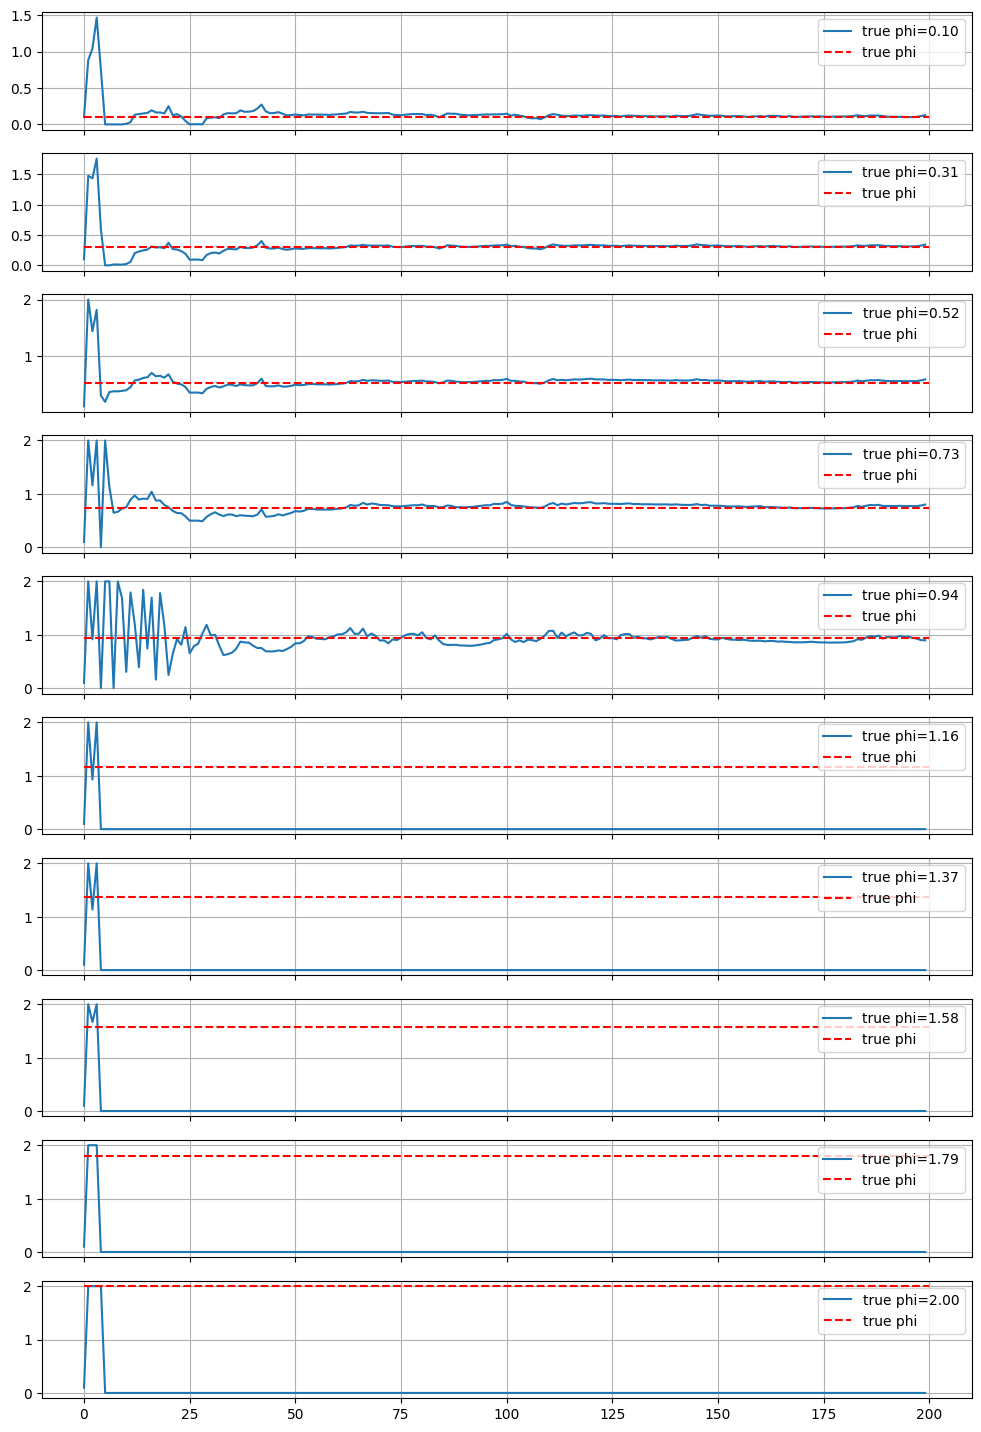

In [19]:
fig, ax = plt.subplots(figsize=(12, 18), nrows=len(results.keys()), sharex=True)
for i, items in enumerate(results.items()):
    true_phi, guesses = items
    ax[i].plot(guesses, label=f"true phi={true_phi:.2f}")
    ax[i].hlines(y=true_phi, xmin=0, xmax=len(guesses), label="true phi", linestyle="dashed", color="red")
    ax[i].grid()
    ax[i].legend()

In [20]:
results = {}
for phi in np.linspace(0.01, 1, 10):
    states, observations = simulate(T, phi, seed=0)
    guesses = estimate_params_vec(T=200, observations=observations, N=1000)
    results[phi] = guesses

Iteration 1/199, phi = 0.5856577684413695
Iteration 2/199, phi = 0.7377636824011006
Iteration 3/199, phi = 1.2214809942694949
Iteration 4/199, phi = 0.8049165558508333
Iteration 5/199, phi = 0.001
Iteration 6/199, phi = 0.001
Iteration 7/199, phi = 0.001
Iteration 8/199, phi = 0.0030586557642046136
Iteration 9/199, phi = 0.001
Iteration 10/199, phi = 0.007704329303429773
Iteration 11/199, phi = 0.026464317487516355
Iteration 12/199, phi = 0.11134592417797004
Iteration 13/199, phi = 0.11652755829636835
Iteration 14/199, phi = 0.12078277193177411
Iteration 15/199, phi = 0.1279706034467721
Iteration 16/199, phi = 0.15995300494966186
Iteration 17/199, phi = 0.12372146422930688
Iteration 18/199, phi = 0.1200787268688176
Iteration 19/199, phi = 0.10661544241167815
Iteration 20/199, phi = 0.20793917288617075
Iteration 21/199, phi = 0.07413870931299293
Iteration 22/199, phi = 0.09715700936235727
Iteration 23/199, phi = 0.06530165734008853
Iteration 24/199, phi = 0.001
Iteration 25/199, phi = 0

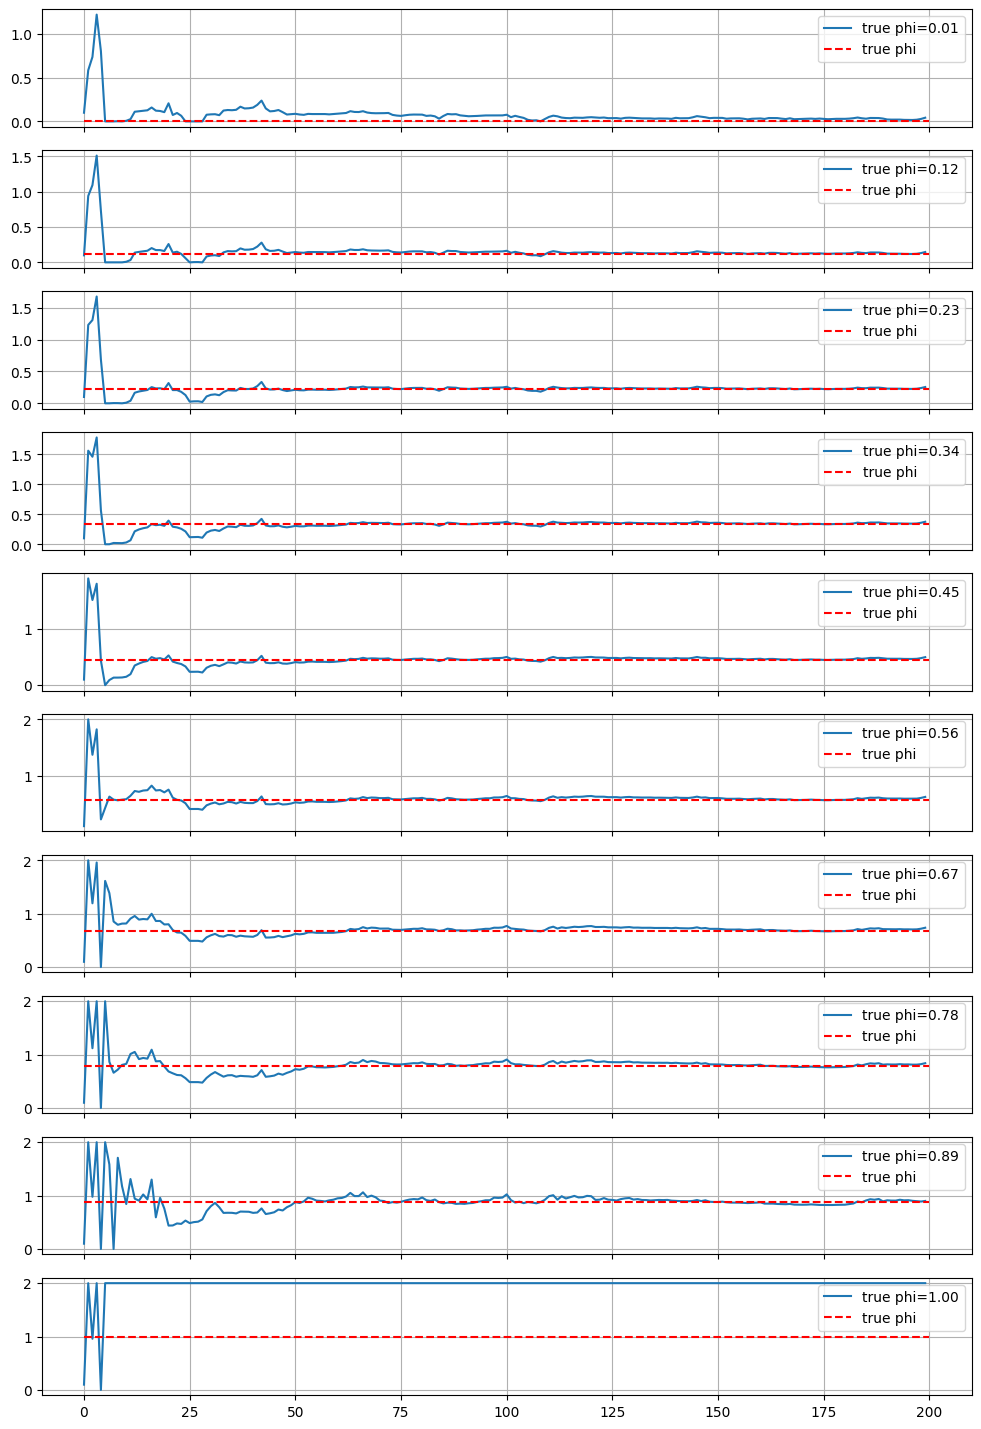

In [21]:
fig, ax = plt.subplots(figsize=(12, 18), nrows=len(results.keys()), sharex=True)
for i, items in enumerate(results.items()):
    true_phi, guesses = items
    ax[i].plot(guesses, label=f"true phi={true_phi:.2f}")
    ax[i].hlines(y=true_phi, xmin=0, xmax=len(guesses), label="true phi", linestyle="dashed", color="red")
    ax[i].grid()
    ax[i].legend()